# Object Recognition (Cifar-10 dataset)

## Importing required packages

here i have imported all the important packages required for the object recognition task.


In [1]:
import numpy as np
from keras import applications
from keras.models import Sequential, Model 
from keras import optimizers
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import Adam
import h5py
from keras.callbacks import ModelCheckpoint   
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

Using TensorFlow backend.


## Loading Dataset

Cifar-10 dataset is made available by keras through its Datasets packages. I have used this package just to save the hassle of downloading the dataset and then converting it to required size. 

after loading the data i have defined a method prep_pixels() so as to normalize and rescale the data.

In [2]:
# loading train and test dataset
def load_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [3]:
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm



## FIRST APPROACH : defining the model (Transfer learning aproach)

I am using the VGG19 model for the task. VGG19 has 19 layer arhitecture. here i decided to go with not reshaping the original size of the image provided in the cifar-10 dataset and as a result i have kept all the layers of the network as trainable.

I have given include_top parameter as False so i am not using the Fully Connected layers of VGG19 model and thus i have defined my own Dense(fully connected) layers with last layers giving 10 outputs i.e the no. of classes we have in cifar-10 dataset.



In [21]:
# define model
def define_model():
    model = applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
    """for layer in model.layers:
        layer.trainable = False""" 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(10, activation="softmax")(x)
    model_final = Model(input = model.input, output = predictions)
    model.summary()
    model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

    return model_final
define_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


## plotting loss and accuracy (for test and validation)

In [4]:

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='black', label='val')

    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='black', label='val')

    pyplot.show()
 


## assembling the methods

creating a skelton method for all the method defined above.

In [23]:
# run the test harness for evaluating a model
def Skeleton():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    print("Data loaded")
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    print("prepared pixels")
    # define model
    model = define_model()
    print("model defined")
    
    # fit model
    checkpointer = ModelCheckpoint(filepath='model_best.h5', 
                               verbose=1, save_best_only=True, save_weights_only = True)    
    history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_split = 0.2,
                        callbacks = [checkpointer], verbose=1, shuffle = True)
    print(".....")
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)


Data loaded
prepared pixels


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

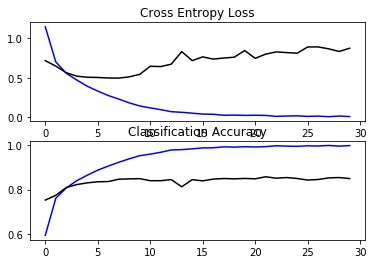

In [25]:
Skeleton()

## SECOND APPROACH: CNN with data augmentation and batch normalization

In [5]:
def define_model_2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# run the test harness for evaluating a model
def Skeleton_2():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    print("Data loaded")
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    print("prepared pixels")
    # define model
    model = define_model_2()
    print("model defined")
    # fit model
    checkpointer = ModelCheckpoint(filepath='model_best1.h5', 
                               verbose=1, save_best_only=True, save_weights_only=True)    
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

    it_train = datagen.flow(trainX, trainY, batch_size=64)
    # fit model
    steps = int(trainX.shape[0] / 64)
    history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=200,
                                  validation_data=(testX, testY), callbacks=[checkpointer], verbose=1)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

Data loaded


W0630 12:19:42.017114 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 12:19:42.048548 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 12:19:42.055153 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 12:19:42.090164 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

prepared pixels


W0630 12:19:45.507943 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0630 12:19:45.674919 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0630 12:19:45.682949 140277725554432 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0630 12:19:46.370903 140277725554432 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/pyt

model defined
Epoch 1/200
781/781 [==============================] - 34s 44ms/step - loss: 2.1412 - acc: 0.2974 - val_loss: 1.4973 - val_acc: 0.4450

Epoch 00001: val_loss improved from inf to 1.49734, saving model to model_best1.h5
Epoch 2/200
781/781 [==============================] - 26s 33ms/step - loss: 1.6395 - acc: 0.3985 - val_loss: 1.3879 - val_acc: 0.4920

Epoch 00002: val_loss improved from 1.49734 to 1.38785, saving model to model_best1.h5
Epoch 3/200
781/781 [==============================] - 26s 33ms/step - loss: 1.5113 - acc: 0.4458 - val_loss: 1.3797 - val_acc: 0.4920

Epoch 00003: val_loss improved from 1.38785 to 1.37969, saving model to model_best1.h5
Epoch 4/200
781/781 [==============================] - 26s 33ms/step - loss: 1.4305 - acc: 0.4795 - val_loss: 1.3297 - val_acc: 0.5164

Epoch 00004: val_loss improved from 1.37969 to 1.32971, saving model to model_best1.h5
Epoch 5/200
781/781 [==============================] - 26s 33ms/step - loss: 1.3678 - acc: 0.5023 

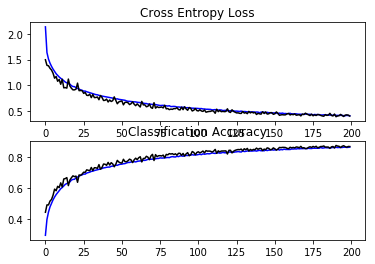

In [7]:
Skeleton_2()

## Conclusion

I have tried two different approaches:

1. using Transfer Learning(VGG19 model):
    Accuracy on test set using transfer learning was 84.200.


2. using CNN network with Augmentation and Normalization :
    Accuracy on test set using this method was 86.530.


As per results CNN model is performing better whereas both models can be made to perform slightly better by tweaking some parameters or training for more epochs.
In transfer learning model resizing images to the size of images on which the VGG19 model is having pre trained weights could give significantly better results.